# Проверка статистических гипотез.

**Задача: приоритизировать гипотезы и провести A/B тестирование**

## Приоритезация гипотез

In [1]:
# Выгрузим все необходимые библиотеки 
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import seaborn as sns
import scipy.stats as stats

### Параметр ICE

In [2]:
# Откроем файл с гипотезами
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep=',')
except:
    hypothesis = pd.read_csv('hypothesis.csv', sep=',')


In [3]:
#Приоритезируем гипотезы параметром ICE
hypothesis['ICE'] = ((hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']).round()

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150 

#выделим цветом
cm = sns.light_palette("green", as_cmap=True)


#Сортируем по убыванию
hypothesis.sort_values(by='ICE', ascending=False).style.background_gradient(cmap=cm)


,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.000000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.000000


Расчитав параметр ICE мы видим что гипотезы:

- **Запустить акцию, дающую скидку на товар в день рождения**
- **Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей**
- **Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**

находятся в приоритете

### Параметр RICE

In [4]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150


hypothesis.sort_values(by='RICE', ascending=False).style.background_gradient(cmap=cm)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.000000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.000000,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.000000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.000000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.000000,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.000000


Применив фреймворк RICE, мы видим что гипотезы
- **Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**
- **Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа**
- **Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей**

 находятся в приритете. Однако на первом месте гипотеза **Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**.

**Вывод:**

Применив два фреймворка ICE и RICE мы увидели расхождение в приоритетах гипотез.
Это произошло из-за добавления параметра Reach в фреймворке RICE. 
И в ICE и в RICE в топ-3 попадают гипотезы:

- **Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**
- **Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей**

Рекомендую начать анализ этих гипотез в первую очередь.

## Анализ A/B теста

#### Информация таблицы Orders

In [5]:
#откроем фрейм с заказами
try:
    orders = pd.read_csv('/datasets/orders.csv', sep=',')
except:
    orders = pd.read_csv('orders.csv', sep=',')
    
#информация о данных таблицы
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
#преобразовываем тип данных в нужный тип
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


#### Информация таблицы visitors

In [7]:
#таблица с пользователями
try:
    visitors = pd.read_csv('/datasets/visitors.csv', sep=',')
except:
    visitors = pd.read_csv('visitors.csv', sep=',')
#информация о таблице visitors
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [8]:
#преобразование типов данных таблицы visitors
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


**Пропусков в таблице нет, типы данных приведены в нужный вид.**

**Посмотрим есть ли у нас пользователи которые попали в две группы одновременно**

In [9]:
double_visitors = orders.groupby('visitorId', as_index=False)\
.agg({'group': 'nunique'}).sort_values(by='group', ascending=False)
double_visitors
double_visitors[double_visitors['group'] == 2]['visitorId'].count()

58

58 пользователей находятся в двух группах сразу, это почти 5% от всего количества пользователей, это много 

### Визуализация графиков.

#### Подготовка кумулятивных данных

In [10]:
#создадим массив уникальных пар значений дат и групп
groupDates = orders[['date', 'group']].drop_duplicates()

#собираем агрегированные данные по дням
aggregatedOrders = groupDates\
.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
       .agg({'date': 'max', 'group':'max', 'visitorId': 'nunique', 'transactionId': 'nunique', 'revenue': 'sum'}), axis=1)\
.sort_values(by=['date','group'])


aggregatedVisitors = groupDates\
.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
                                     .agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}), axis=1)\
.sort_values(by=['date', 'group'])

# объединим два агрегированных фрейма в один

cumulativeData = aggregatedOrders.merge(aggregatedVisitors, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()


,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,20,24,148579,719
1,2019-08-01,B,20,21,101217,713
2,2019-08-02,A,38,44,242401,1338
3,2019-08-02,B,43,45,266748,1294
4,2019-08-03,A,62,68,354874,1845


Получили фрейм с агрегированными кумулятивными данными, теперь приступаем к построению графиков.

#### График кумулятивной выручки

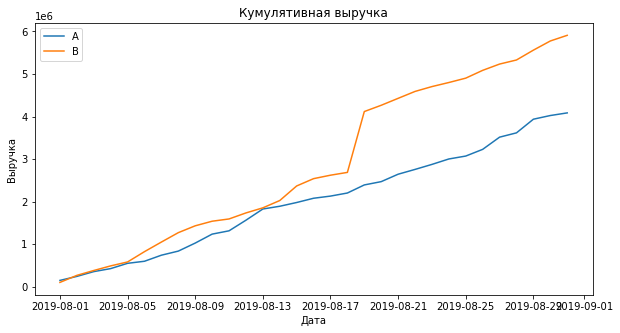

In [33]:
#создадим датафреймы с кумулятивной выручкой и количеством заказов по дням для каждой группы
cumulativeRevenue_A = cumulativeData[cumulativeData['group'] == 'A'][['date', 'orders', 'revenue']]

cumulativeRevenue_B = cumulativeData[cumulativeData['group'] == 'B'][['date', 'orders', 'revenue']]

#график кумулятивной выручки
plt.figure(figsize=(10,5))

plt.plot(cumulativeRevenue_A['date'], cumulativeRevenue_A['revenue'], label = 'A')

plt.plot(cumulativeRevenue_B['date'], cumulativeRevenue_B['revenue'], label = 'B')

plt.legend()

plt.title('Кумулятивная выручка')
plt.ylabel('Выручка')
plt.xlabel('Дата')

#plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            #arrowprops=dict(facecolor='g'))
#plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            #arrowprops=dict(facecolor='g'))

plt.show()

По началу две группы коррелируют, потом группа В резко обгоняет группу А, предполагаю что в данных есть выбросы.

#### График кумулятивного среднего чека

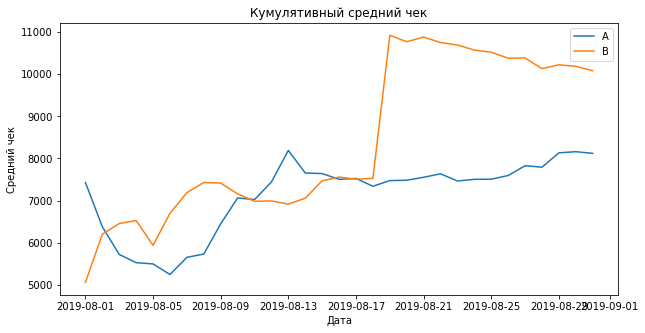

In [34]:
plt.figure(figsize=(10,5))
plt.title('Кумулятивный средний чек')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.plot(cumulativeRevenue_A['date'], cumulativeRevenue_A['revenue'] / cumulativeRevenue_A['orders'], label='A')
plt.plot(cumulativeRevenue_B['date'], cumulativeRevenue_B['revenue'] / cumulativeRevenue_B['orders'], label='B')

#plt.annotate('скачок', xy=('2019-08-18', 7500), xytext=('2019-08-13', 9000),  arrowprops=dict(arrowstyle='->'))

plt.legend()
plt.show()

**Вывод:**

Средний чек группы А в начале просел относительно группы В и начиная с середины стал равномерным, тогда как средний чек группы В изначально стремительно рос, а начиная с середины вырос очень сильно. Это может говорить о том что в выборке есть выбросы в виде очень дорогих заказов. Это надо проверить.

#### График относительного изменения  кумулятивного среднего чека группы В к группе А

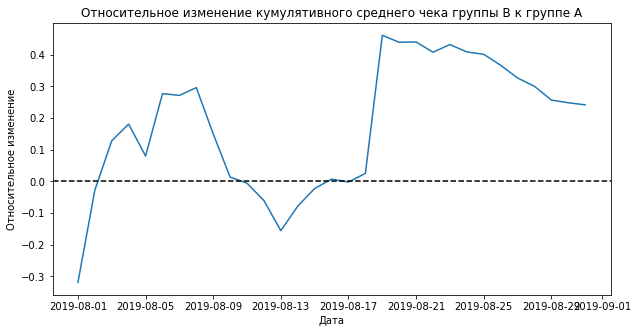

In [35]:
cumulativeRevenue_merge = cumulativeRevenue_A.merge(
    cumulativeRevenue_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10,5))

plt.plot(cumulativeRevenue_merge['date'],\
         (cumulativeRevenue_merge['revenueB'] / cumulativeRevenue_merge['ordersB']) / (cumulativeRevenue_merge['revenueA'] / cumulativeRevenue_merge['ordersA']) -1)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.show()

**Вывод:**

В нескольких местах график сильно "скачет", значит в выборке есть очень дорогие заказы, которые портят общую картину.

#### График кумулятивной конверсии

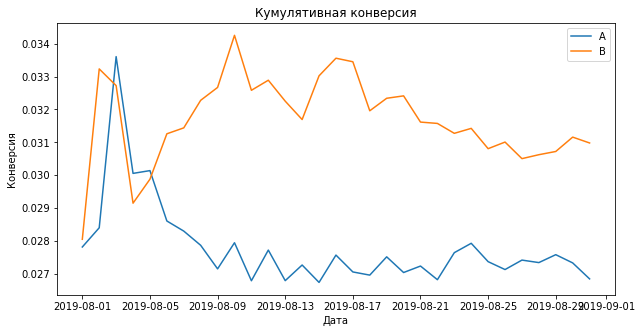

In [36]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

cumulativeConversion_A = cumulativeData[cumulativeData['group'] == 'A']

cumulativeConversion_B = cumulativeData[cumulativeData['group'] == 'B']

plt.figure(figsize=(10,5))
plt.plot(cumulativeConversion_A['date'], cumulativeConversion_A['conversion'], label='A')
plt.plot(cumulativeConversion_B['date'], cumulativeConversion_B['conversion'], label='B')
plt.legend()
plt.title('Кумулятивная конверсия')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()

**Вывод:**

На графике кумулятивной конверсии видим раскорреляцию, в начале группы идут одинаково потом происходит резкое расхождение у группы В конверсия возрастает, а для группы А убывает. 

#### График относительной кумулятивной конверсии группы В к группе А

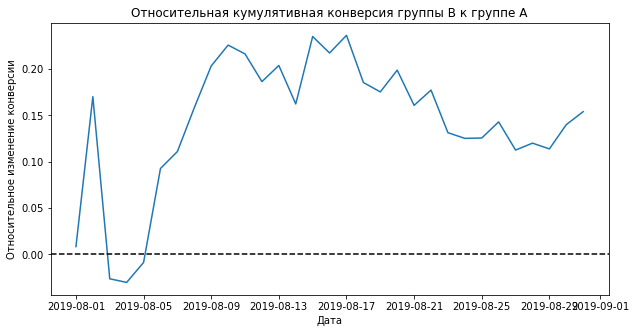

In [37]:
cumulativeMergeConversion = pd.merge(cumulativeConversion_A[['date', 'conversion']],\
                                     cumulativeConversion_B[['date', 'conversion']],left_on='date',\
                                     right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10,5))
plt.plot(cumulativeMergeConversion['date'],\
         cumulativeMergeConversion['conversionB'] / cumulativeMergeConversion['conversionA'] -1)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительная кумулятивная конверсия группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение конверсии')
plt.show()

**Вывод:** В целом отношение конверсии группы В к группе А считаю установленным. Выигрывает группа В.

#### Точечный график количества заказов по пользователям

In [38]:
userOrders = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))

userOrders.columns = ['visitorId', 'orders']

userOrders.sort_values(by='orders', ascending=False).head()

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


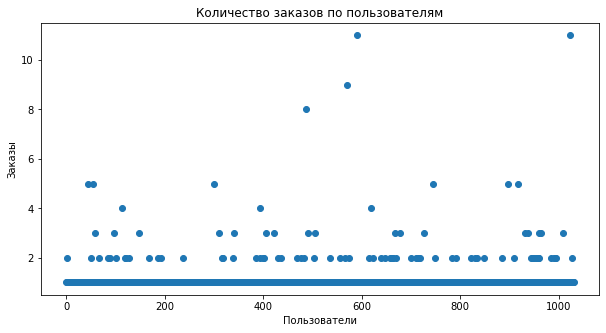

In [39]:
x_values = pd.Series(range(0, len(userOrders)))

plt.figure(figsize=(10,5))
plt.scatter(x_values, userOrders['orders'])
plt.title('Количество заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Заказы')
plt.show()

In [40]:
#Найдем 95 и 99 перцентили для определения границ аномальных заказов.
np.percentile(userOrders['orders'], [95, 99])

array([2., 4.])

**Вывод:** Всего 5% процентов пользователей заказывало более 2-ух раз и 1% пользователей заказывало более 4-ех раз. Все заказы выше 3-ех будем считать аномальными.

#### График стоимостей заказов

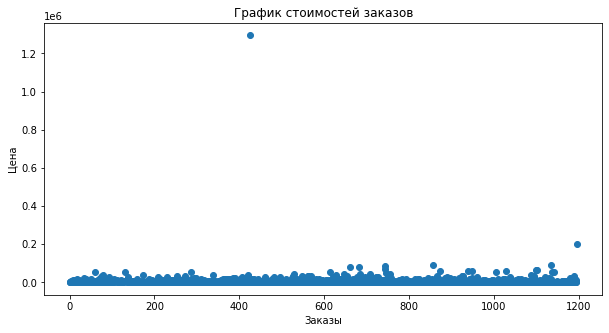

In [19]:
x_values_revenue = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(10,5))
plt.scatter(x_values_revenue, orders['revenue'])
plt.title('График стоимостей заказов')
plt.ylabel('Цена')
plt.xlabel('Заказы')
plt.show()

In [20]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Получается что не более 5% заказов дороже 28000 и не более 1% заказов дороже 58232. Все заказы свыше 58000 будем считать аномальными.

#### Подготовка "сырых" данных для расчета статистической значимости конверсии и среднего чека.

In [41]:
#найдем коверсию группы А
visitorsDaily_A = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsDaily_A.columns = ['date', 'visitorsPerDateA']

visitorsDaily_A_cummulative = visitorsDaily_A.apply(
    lambda x: visitorsDaily_A[visitorsDaily_A['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)

visitorsDaily_A_cummulative.columns = ('date', 'visitors_cummulative_A')


#аналогично найдем конверсию для группы В
visitorsDaily_B = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsDaily_B.columns = ['date', 'visitorsPerDateB']

visitorsDaily_B_cummulative = visitorsDaily_B.apply(
    lambda x: visitorsDaily_B[visitorsDaily_B['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)

visitorsDaily_B_cummulative.columns = ['date', 'visitors_cummulative_B']


**Найдем дневные значения выручки и заказов группы А (сырые данные)**

In [42]:
orders_daily_users_A = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitorId': pd.Series.nunique, 'revenue':'sum'})
)

orders_daily_users_A.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

orders_cummulative_A = orders_daily_users_A.apply(
    lambda x: orders_daily_users_A[orders_daily_users_A['date'] <= x['date']].agg(
        {'date':'max', 'ordersPerDateA':'sum', 'revenuePerDateA':'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_A.columns = ['date', 'orderscummulativeA', 'revenuecummulativeA']


In [43]:
#аналогично для группы В
orders_daily_users_B = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitorId': pd.Series.nunique, 'revenue':'sum'})
)

orders_daily_users_B.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

orders_cummulative_B = orders_daily_users_B.apply(
    lambda x: orders_daily_users_B[orders_daily_users_B['date'] <= x['date']].agg(
        {'date':'max', 'ordersPerDateB':'sum', 'revenuePerDateB':'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_B.columns = ['date', 'orderscummulativeB', 'revenuecummulativeB']


In [44]:
data_merge = (
    orders_daily_users_A.merge(
        orders_daily_users_B, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cummulative_A, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_B, left_on='date', right_on='date', how='left')
    .merge(visitorsDaily_A, left_on='date', right_on='date', how='left')
    .merge(visitorsDaily_B, left_on='date', right_on='date', how='left')
    .merge(visitorsDaily_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsDaily_B_cummulative, left_on='date', right_on='date', how='left')
)

data_merge.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,orderscummulativeA,revenuecummulativeA,orderscummulativeB,revenuecummulativeB,visitorsPerDateA,visitorsPerDateB,visitors_cummulative_A,visitors_cummulative_B
0,2019-08-01,20,148579,20,101217,20,148579,20,101217,719,713,719,713
1,2019-08-02,19,93822,23,165531,39,242401,43,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,63,354874,59,380996,507,509,1845,1803
3,2019-08-04,15,70825,16,108571,78,425699,75,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,103,549917,98,581995,756,707,3318,3280


Получили датафрейм с сырыми данными

In [45]:
#создадим таблицы с количеством покупок пользователей
orderByusers_A = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

orderByusers_A.columns = ['visitorId', 'orders']


orderByusers_B = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

orderByusers_B.columns = ['visitorId', 'orders']

#### Статистическая значимость различий в конверсии между группами по «сырым» данным

Сформулируем гипотезу:

- H<sub>0</sub>(нулевая гипотеза) - Разница между двумя группами в конверсии статистически не значима

- H<sub>1</sub>(альтернативная гипотеза) - Разница между двумя группами в конверсии статистически значима

In [46]:
sampleA = pd.concat(
    [
        orderByusers_A['orders'],
        pd.Series(
            0,
            index=np.arange(
                data_merge['visitorsPerDateA'].sum() - len(orderByusers_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        orderByusers_B['orders'],
        pd.Series(
            0,
            index=np.arange(
                data_merge['visitorsPerDateB'].sum() - len(orderByusers_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))

print("Относительный выигрыш группы В = {0:.3%}".format(sampleB.mean() / sampleA.mean() - 1))
 


p-value: 0.017
Относительный выигрыш группы В = 13.808%


**Вывод:**

p-value больше 0.05, а значит нулевую гипотезу о статистических различиях в конверсии между группами не отвергаем.
Расхождение между группами  в 13.8%

#### Статистическая значимость в среднем чеке по "сырым" данным

Сформулируем гипотезу:

- H<sub>0</sub>(нулевая гипотеза) - Различия между группами в среднем чеке статистически не значимы.

- H<sub>1</sub>(альтернативная гипотеза) - Различия между группами в среднем чеке статистически значимы. 

In [27]:
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(
    orders[orders['group'] == 'A']['revenue'],
    orders[orders['group'] == 'B']['revenue'], alternative='two-sided')[1]))
    

print('{0:.3f}'.format(
    orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean() -1))

p-value = 0.729
0.259


p-value = 0.729 Нулевую гипотезу о статических различиях в среднем чеке между группами не отвергаем.

Средний чек группы В значительно выше среднего чека группы А расхождение в 26%

#### Статистическая значимость различий в конверсии между группами по "очищенным" данным. 

Сформулируем гипотезу:

- H<sub>0</sub>(нулевая гипотеза) - Разница между двумя группами в конверсии статистически не значима (по очищенным данным)

- H<sub>1</sub>(альтернативная гипотеза) - Разница между двумя группами в конверсии статистически значима (по очищенным данным)

In [47]:
usersManyOrders = pd.concat(
    [
        orderByusers_A[orderByusers_A['orders'] > 3]['visitorId'],
        orderByusers_B[orderByusers_B['orders'] > 3]['visitorId'],
    ],
    axis=0
)

expensiveOrders = orders[orders['revenue'] > 58234]['visitorId']

ABnormalusers = pd.concat([usersManyOrders, expensiveOrders], axis=0).drop_duplicates().sort_values()

ABnormalusers.shape

(20,)

У нас получилось всего 20 пользователей с аномальными значениями, уберем их.

In [48]:
filteredsample_A = pd.concat(
    [
        orderByusers_A[
            np.logical_not(orderByusers_A['visitorId'].isin(ABnormalusers))
        ]['orders'],
        pd.Series(0,
                 index=np.arange(
                     data_merge['visitorsPerDateA'].sum() - len(orderByusers_A['orders']),
                 ),
                  name='orders',
                 ),
    ],
    axis=0,
)

filteredsample_B = pd.concat(
    [
        orderByusers_B[
            np.logical_not(orderByusers_B['visitorId'].isin(ABnormalusers))
        ]['orders'],
        pd.Series(0,
                 index=np.arange(
                     data_merge['visitorsPerDateB'].sum() - len(orderByusers_B['orders']),
                 ),
                  name='orders',
                 ),
    ],
    axis=0,
)

In [49]:
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(filteredsample_A,filteredsample_B, alternative='two-sided')[1]))
print('{0:.3f}'.format(filteredsample_B.mean() / filteredsample_A.mean() -1))

p-value = 0.014
0.151


По "очищенным" данным видно что p-value снизилось до 0.014, но так как p-value больше 0.05, то нулевую гипотезу о статистических различиях в конверсиии не отвергаем, расхождение увеличилось до 15%

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Сформулируем гипотезу:

- H<sub>0</sub>(нулевая гипотеза) - Различия между группами в среднем чеке статистически не значимы.(по очищенным данным)

- H<sub>1</sub>(альтернативная гипотеза) - Различия между группами в среднем чеке статистически значимы.(по очищенным данным) 

In [50]:
print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(ABnormalusers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(ABnormalusers)),
                )
            ]['revenue'],
         alternative = 'two-sided')[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(ABnormalusers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(ABnormalusers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 


p-value = 0.959
-0.014


p-value среднего чека составляет по "очищенным" данным составляет 0.959 когда по сырым p-value составляет 0.729. 

Разница по сегментам уменьшилась до 1.4%

### Вывод

1. **Приоритезация гипотез:**

Расчитав параметр ICE мы видим что гипотезы:

- **Запустить акцию, дающую скидку на товар в день рождения**
- **Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей**
- **Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**

находятся в приоритете



1.1 Применив фреймворк RICE, мы видим что гипотезы:

- **Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**

- **Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа**

- **Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей**

находятся в приритете. Однако на первом месте гипотеза Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

Вывод по приоритезации гипотез:

Применив два фреймворка ICE и RICE мы увидели расхождение в приоритетах гипотез. Это произошло из-за добавления параметра Reach в фреймворке RICE. И в ICE и в RICE в топ-3 попадают гипотезы:

- **Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**
- **Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей**

Рекомендую начать анализ этих гипотез в первую очередь.

При ознакомлении с датафреймом orders заметил что 58 пользователей находятся в двух группах сразу, это почти 5% от всего количества пользователей.


**2. Итоги А/Б тестирования:**

**2.1   Статистическая значимость различий в конверсии между группами по "сырым" и "очищенным" данным.**

- H<sub>0</sub>(нулевая гипотеза) - Разница между двумя группами в конверсии статистически не значима

- H<sub>1</sub>(альтернативная гипотеза) - Разница между двумя группами в конверсии статистически значима

По "сырым": 
p-value: 0.017
Относительный выигрыш группы В = 13.808%

Так как p-value больше 0.05, Нулевую гипотезу не отвергаем ,но расхождение между группами составляет в 13.8%

По "очищенным":
- H<sub>0</sub>(нулевая гипотеза) - Разница между двумя группами в конверсии статистически не значима (по очищенным данным)

- H<sub>1</sub>(альтернативная гипотеза) - Разница между двумя группами в конверсии статистически значима (по очищенным данным)

p-value = 0.014, так как p-value больше 0.05, то нулевую гипотезу не отвергаем, но расхождение между группами в среднем чеке увеличилось до 15%

**Заключение:** 
Между "сырыми" данными и "очищенными" в конверсии мы видим статистически значимые различия:
в "сырых" данных p-value =  0.017, а в "очищеннных" p-value = 0.014    
Расхождение в разнице между сегментами составляет по "сырым" данным 13.8% , по "очищенным" 15%
Считаю что расхождения более 10% статистически значимыми. Расхождения в сторону группы В

**2.2 Статистическая значимость в среднем чеке по "сырым" и "очищенным" данным:**

По "сырым":
- H<sub>0</sub>(нулевая гипотеза) - Различия между группами в среднем чеке статистически не значимы.

- H<sub>1</sub>(альтернативная гипотеза) - Различия между группами в среднем чеке статистически значимы. 

p-value = 0.729 

Нулевую гипотезу не отвергаем, но средний чек группы В значительно выше среднего чека группы А расхождение в 26%

По "очищенным:

- H<sub>0</sub>(нулевая гипотеза) - Различия между группами в среднем чеке статистически не значимы.

- H<sub>1</sub>(альтернативная гипотеза) - Различия между группами в среднем чеке статистически значимы. 


p-value среднего чека составляет по "очищенным" данным составляет 0.959. Разница по сегментам уменьшилась до 1.4%.

Скорее всего разница уменьшилась из-за того что мы убрали аномальные заказы.

**Заключение:** 
В исследовании статистически значимых расхождениях в среднем чеке в "сырых" и "очищенных" данных мы видим что расхождения есть, но не большие:
в "сырых" p-value = 0.729, а в "очищенных" p-value = 0.959.

Зато есть сильное расхождение в разнице между сегментами в "сырых" данных в 26%, а в "очищенных" расхождения всего 1.4%.
Это произошло из-за того что мы убрали аномально дорогие заказы.

**2.3 Анализ кумулятивных графиков**

На графике различия конверсии между группами видно группа B сильно выбилась вперед. Так же это видно на графике различия среднего чека группа B выбивается вперед и есть тенденция к улучшению.

<b>Исходя из всех этих фактов считаю, что тест нужно остановить и признать его успешным.

Признать что группа B победила. Так как средний чек не упал а конверсия увеличилась то победа группы может дать продукту новых пользователей, которые увеличат число заказов.</b>
